In [10]:
import pandas as pd
import glob
import os
import re

# Specify the folder containing .sc files
SC_FOLDER = "collected_scores"  # Replace with your folder name

# Function to extract identifier from filename
def get_identifier(filename):
    # Split by underscore and take elements between first and third underscore
    parts = filename.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return filename  # fallback if pattern doesn't match

# Function to process a single .sc file
def process_sc_file(filepath):
    # Read the file, skip the first line (SEQUENCE:), use whitespace as separator
    df = pd.read_csv(filepath, delim_whitespace=True, skiprows=1)
    
    # Filter rows that start with "SCORE:"
    df = df[df['SCORE:'] == 'SCORE:']
    
    # Convert total_score to numeric, it's the second column
    total_scores = pd.to_numeric(df.iloc[:, 1])
    
    return total_scores.mean(), total_scores.std()

# Main processing
results = []

# Loop through all .sc files in the specified folder
for filepath in glob.glob(os.path.join(SC_FOLDER, "*.sc")):
    try:
        # Get identifier from filename
        identifier = get_identifier(os.path.basename(filepath))
        
        # Process file
        mean_energy, std_energy = process_sc_file(filepath)
        
        # Store results
        results.append({
            'identifier': identifier,
            'mean_energy': mean_energy,
            'std_energy': std_energy
        })
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")

# Create final dataframe
results_df = pd.DataFrame(results)
results_df.set_index('identifier', inplace=True)
results_df = results_df.reset_index()
results_df[['structure', 'sequence']] = results_df['identifier'].str.split('_',expand=True)



In [12]:
results_df

,identifier,mean_energy,std_energy,structure,sequence
0,2kdl_GB95,154.2661,2.748019e-01,2kdl,GB95
1,2kdm_GA95,31.3222,1.523545e+00,2kdm,GA95
2,2kdm_GB95,26.3332,2.283229e+00,2kdm,GB95
3,2kdl_GA95,98.6670,1.497956e-14,2kdl,GA95
4,2kdm_GA77,51.0196,1.444267e+00,2kdm,GA77
5,2kdl_GB77,185.1929,3.594349e-01,2kdl,GB77
6,2kdl_GA77,129.3413,8.313220e-01,2kdl,GA77
7,2kdm_GB77,92.4701,1.451501e-01,2kdm,GB77


True
False


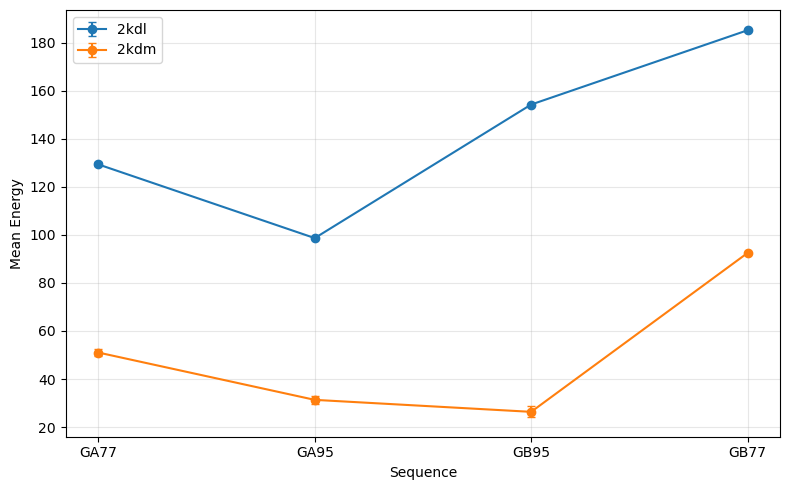

In [27]:
# Plot
import numpy as np
plt.figure(figsize=(8, 5))
sequence_order = ['GA77', 'GA95', 'GB95', 'GB77']

for struct in ['2kdl', '2kdm']:
    print(struct == '2kdl')
    subset = results_df[results_df['structure'] == struct].set_index('sequence')
    means = [subset.loc[seq, 'mean_energy'] if seq in subset.index else None for seq in sequence_order]
    stds = [subset.loc[seq, 'std_energy'] if seq in subset.index else None for seq in sequence_order]
    plt.errorbar(sequence_order, np.array(means) - (struct == '2kdl')*0, yerr=stds, fmt='o-', capsize=3, label=struct)

plt.xlabel('Sequence')
plt.ylabel('Mean Energy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()